In [1]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/rasbt/'
                 'python-machine-learning-book-2nd-edition'
                 '/master/code/ch10/housing.data.txt',
                 header = None, sep = '\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM',
              'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B',
              'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


# EDA

### scatterplot matrix

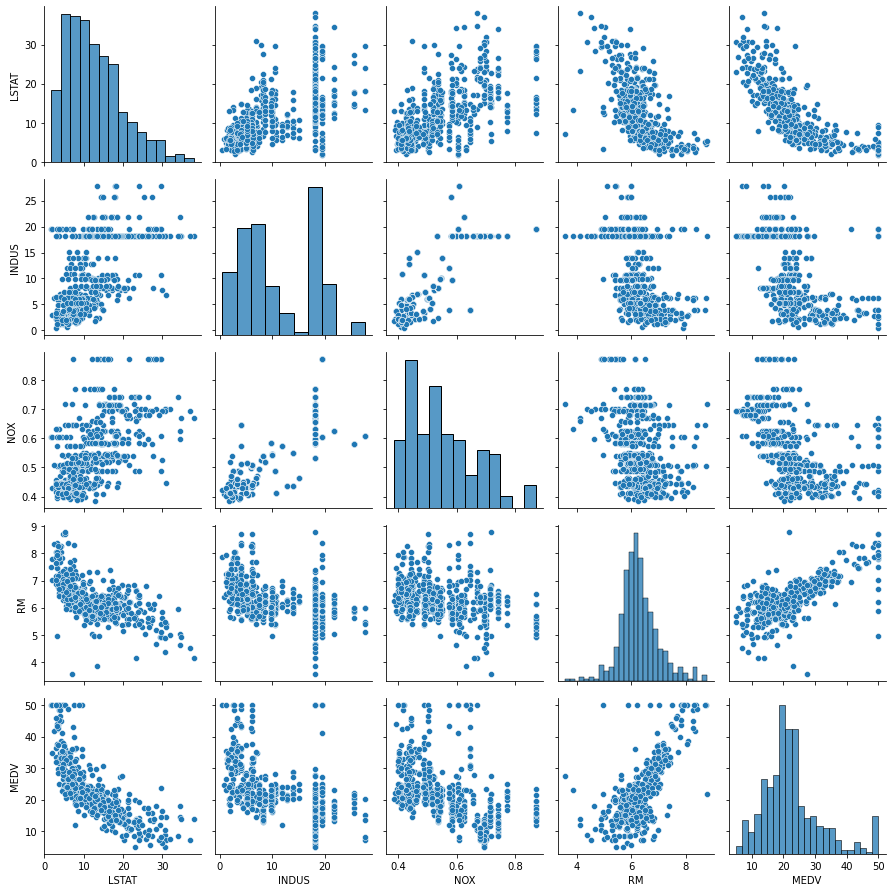

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
sns.pairplot(df[cols], height = 2.5)
plt.tight_layout()
plt.show()

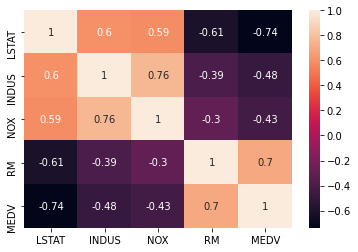

In [10]:
import numpy as np

cm = df[cols].corr()
sns.heatmap(cm, cbar=True, annot = True)
plt.show()

### 최소 제곱 선형 회귀 모델 구현

- 비용함수 $J(w) = \frac{1}{2}\sum_{i=1}^{n}(y - \hat{y})^{2}$
- $\hat{y} = w^{T}x : 예측값$

In [15]:
class LinearRegressionGD(object):
    def __init__(self, eta = 0.001, n_iter = 20):
        self.eta = eta
        self.n_iter = n_iter
        
    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() /2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        return self.net_input(X)

In [16]:
X = df[['RM']].values
y = df['MEDV'].values

from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten() # 대부분의 변환기는 데이터가 2차원 배열로 저장되어있다고 생각하여 차원을 추가한뒤 flatten을 이용해 다시 1차원으로 되돌림
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

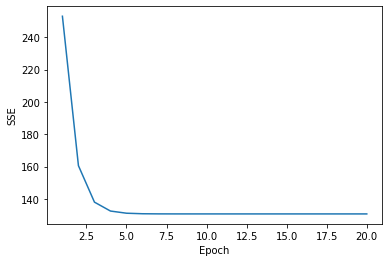

In [17]:
plt.plot(range(1, lr.n_iter + 1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

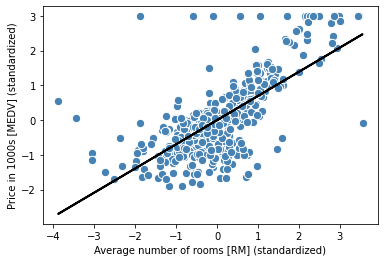

In [18]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c = 'steelblue', edgecolor = 'white', s=70)
    plt.plot(X, model.predict(X), color = 'black', lw=2)
    return None

lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in 1000s [MEDV] (standardized)')
plt.show()

In [22]:
num_rooms_std = sc_x.transform([[5.0]])
price_std = lr.predict(num_rooms_std)
print(f"1000 단위 가격: {sc_y.inverse_transform(price_std)}")

1000 단위 가격: [10.83993289]


In [23]:
print('기울기: ', lr.w_[1])
print('절편: ', lr.w_[0])

기울기:  0.6953594261783849
절편:  -4.831690603168682e-16


# sklearn linearregression

In [24]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X, y)
print('기울기: ', slr.coef_[0])
print('절편: ', slr.intercept_)

기울기:  9.102108981180312
절편:  -34.67062077643857


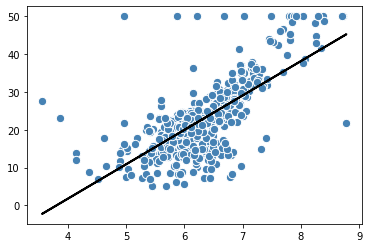

In [25]:
lin_regplot(X, y, slr)
plt.show()

In [26]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(),
                         max_trials = 100, # 최대 반복회수
                         min_samples = 50, # 랜덤하게 선택할 샘플 최소 개수
                         loss = 'absolute_loss', # 학습한 직선과 샘플 간 수직거리의 절대값 계산
                         residual_threshold = 5.0, # 수직거리 5이내 있는 정상 샘플만 포함
                         random_state = 0)
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(), min_samples=50,
                random_state=0, residual_threshold=5.0)

### 선형 회귀 모델 성능평가

In [54]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

### residual plot

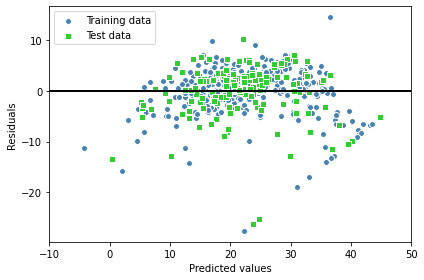

In [55]:
plt.scatter(y_train_pred, y_train_pred - y_train,
            c = 'steelblue', marker = 'o', edgecolor = 'white',
            label = 'Training data')
plt.scatter(y_test_pred, y_test_pred - y_test,
            c = 'limegreen', marker = 's', edgecolor = 'white',
            label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = -10, xmax = 50, color = 'black', lw = 2)
plt.xlim([-10, 50])
plt.tight_layout()
plt.show()

### 평균 제곱 오차
- 제곱 오차합 (SSE)의 평균
- $MSE = \frac{1}{n}\sum_{i=1}^{n}(y_{i}-\hat{y}_{i})^{2}$

In [56]:
from sklearn.metrics import mean_squared_error

print(f"훈련 : {round(mean_squared_error(y_train, y_train_pred), 3)}")
print(f"테스트 : {round(mean_squared_error(y_test, y_test_pred), 3)}")

훈련 : 19.958
테스트 : 27.196


### 결정 계수 (coefficient of determination, R^2)
- 모델 성능을 잘 해석하기 위해 만든 MSE의 표준화된 버전
- R^2 = 타킷의 분산에서 모델이 잡아낸 비율
- $R^{2} = 1-\frac{SSE}{SST}$
- $SST = \sum_{i=1}^{n}(y_{i} - \mu_{y})^{2}$

In [57]:
from sklearn.metrics import r2_score

print(f"훈련 : {round(r2_score(y_train, y_train_pred), 3)}")
print(f"테스트 : {round(r2_score(y_test, y_test_pred), 3)}")

훈련 : 0.765
테스트 : 0.673


# 다항 회귀

### 이차 다항식 항 추가

In [41]:
from sklearn.preprocessing import PolynomialFeatures
X = np.array([258.0, 270.0, 294.0, 320.0, 342.0,
              368.0, 396.0, 446.0, 480.0, 586.0])[:, np.newaxis]
y = np.array([236.4, 234.4, 252.8, 298.6, 314.2,
               342.2, 360.8, 368.0, 391.2, 390.8])[:, np.newaxis]

lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

### 비교를 위한 평범한 선형 회귀 모델

In [42]:
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

### 다항회귀를 위해 변환된 특성에서 다변량 회귀모델 훈련

In [43]:
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

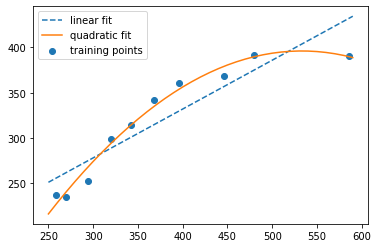

In [44]:
plt.scatter(X, y, label = 'training points')
plt.plot(X_fit, y_lin_fit, label = 'linear fit', linestyle = '--')
plt.plot(X_fit, y_quad_fit, label = 'quadratic fit')
plt.legend(loc = 'upper left')
plt.show()

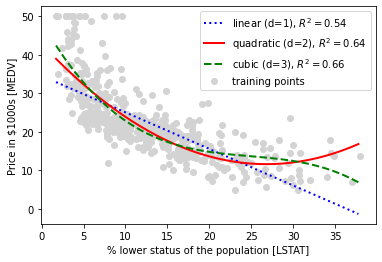

In [46]:
X = df[['LSTAT']].values
y = df['MEDV'].values

regr = LinearRegression()

# 다항식 만들기
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# 그리기 위한 특성 범위
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

plt.scatter(X, y, label = 'training points', color = 'lightgray')

plt.plot(X_fit, y_lin_fit, label = 'linear (d=1), $R^2=%.2f$' % linear_r2,
         color = 'blue', lw = 2, linestyle = ':')

plt.plot(X_fit, y_quad_fit, label = 'quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
         color = 'red', lw = 2, linestyle = '-')

plt.plot(X_fit, y_cubic_fit, label = 'cubic (d=3), $R^2=%.2f$' % cubic_r2,
         color = 'green', lw = 2, linestyle = '--')

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc = 'upper right')
plt.show()

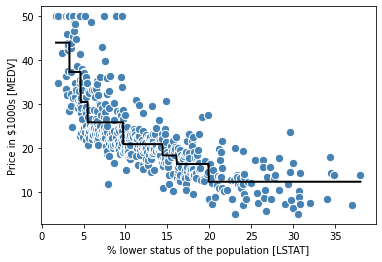

In [47]:
from sklearn.tree import DecisionTreeRegressor

X = df[['LSTAT']].values
y = df['MEDV'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.show()

### randomtreeregressor

In [61]:
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 1)

In [62]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators = 1000, criterion = 'mse',
                               random_state = 1, n_jobs = -1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print(f"훈련 : {round(mean_squared_error(y_train, y_train_pred), 3)}")
print(f"테스트 : {round(mean_squared_error(y_test, y_test_pred), 3)}")
print(f"훈련 : {round(r2_score(y_train, y_train_pred), 3)}")
print(f"테스트 : {round(r2_score(y_test, y_test_pred), 3)}")

훈련 : 1.644
테스트 : 11.085
훈련 : 0.979
테스트 : 0.877


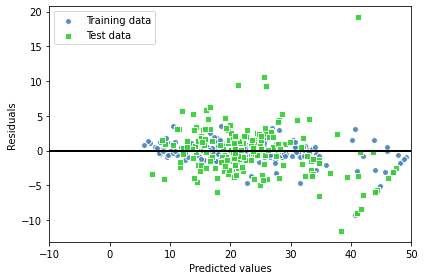

In [63]:
plt.scatter(y_train_pred, y_train_pred - y_train,
            c = 'steelblue', marker = 'o', edgecolor = 'white', s = 35, alpha = 0.9,
            label = 'Training data')
plt.scatter(y_test_pred, y_test_pred - y_test,
            c = 'limegreen', marker = 's', edgecolor = 'white', s = 35, alpha = 0.9,
            label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = -10, xmax = 50, color = 'black', lw = 2)
plt.xlim([-10, 50])
plt.tight_layout()
plt.show()